In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [6]:
 ids = [62,  124,  135,  140,  166,  194,  351,  446,  465,  503,  535,
        581,  600,  612,  613,  616,  808,  820,  830,  873,  924, 1081,
       1088, 1167, 1200, 1201, 1207, 1214, 1232, 1258, 1259, 1308, 1316,
       1359, 1379, 1381, 1401, 1461, 1476, 1483, 1568, 1625, 1655, 1671,
       1709, 1721, 1743, 1766, 1803, 1819, 1824, 1854, 1859, 1873, 1923,
       1934, 1993, 2003, 2026, 2037, 2054, 2104, 2105, 2107, 2108, 2109,
       2124, 2235, 2242, 2278, 2316, 2362, 2373, 2448, 2470, 2475, 2496,
       2501, 2551, 2580, 2630, 2707, 2784, 2805, 2829, 2834, 2842, 2921,
       2930, 2953, 2989, 3029, 3062, 3079, 3110, 3163, 3180, 3213, 3265,
       3302, 3343, 3382, 3398, 3413, 3427, 3480, 3512, 3535, 3547, 3621,
       3623, 3624, 3638, 3656, 3695, 3704, 3713, 3735, 3764, 3779, 3801,
       3808, 3874, 3893, 4057, 4158, 4186, 4269, 4432, 4437, 4451, 4482,
       4491, 4607, 4701, 4770, 4850, 4874, 4888, 4962, 5050, 5087, 5139,
       5140, 5215, 5221, 5249, 5252, 5295, 5378, 5395, 5402, 5568, 5570,
       5658, 5737, 5741, 5742, 5764, 5984, 6137, 6181, 6210, 6214, 6231,
       6272, 6317, 6356, 63580]

In [7]:
len(ids)

169

In [8]:
isin = df.loc[df['caseid'].isin(ids)]

In [9]:
# shrink dataset to the first 6 cases 
caseids = isin.caseid.unique()
caseids


array([  62,  124,  135,  140,  166,  194,  351,  446,  465,  503,  535,
        581,  600,  612,  613,  616,  808,  820,  830,  873,  924, 1081,
       1088, 1167, 1200, 1201, 1207, 1214, 1232, 1258, 1259, 1308, 1316,
       1359, 1379, 1381, 1401, 1461, 1476, 1483, 1568, 1625, 1655, 1671,
       1709, 1721, 1743, 1766, 1803, 1819, 1824, 1854, 1859, 1873, 1923,
       1934, 1993, 2003, 2026, 2037, 2054, 2104, 2105, 2107, 2108, 2109,
       2124, 2235, 2242, 2278, 2316, 2362, 2373, 2448, 2470, 2475, 2496,
       2501, 2551, 2580, 2630, 2707, 2784, 2805, 2829, 2834, 2842, 2921,
       2930, 2953, 2989, 3029, 3062, 3079, 3110, 3163, 3180, 3213, 3265,
       3302, 3343, 3382, 3398, 3413, 3427, 3480, 3512, 3535, 3547, 3621,
       3623, 3624, 3638, 3656, 3695, 3704, 3713, 3735, 3764, 3779, 3801,
       3808, 3874, 3893, 4057, 4158, 4186, 4269, 4432, 4437, 4451, 4482,
       4491, 4607, 4701, 4770, 4850, 4874, 4888, 4962, 5050, 5087, 5139,
       5140, 5215, 5221, 5249, 5252, 5295, 5378, 53

In [10]:
# only keep MBP variable
data = isin[["Solar8000/NIBP_MBP", 'caseid']].copy()

## Preprocessing

In [11]:
MINUTES_AHEAD = 5  # Predict hypotension 1 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 100  # Batch size for learning
MAX_CASES = 600  # Maximum number of cases for this example

In [12]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = data.loc[data.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (150 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 150]
        segy = mbps[i + 150 + MINUTES_AHEAD * 30:i + 150 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 62...4387 samples 82 (1.9 %) events
loading 124...1469 samples 0 (0.0 %) events
loading 135...1671 samples 824 (49.3 %) events
loading 140...2596 samples 0 (0.0 %) events
loading 166...2450 samples 1086 (44.3 %) events
loading 194...3224 samples 80 (2.5 %) events
loading 351...5837 samples 1216 (20.8 %) events
loading 446...3150 samples 0 (0.0 %) events
loading 465...3553 samples 68 (1.9 %) events
loading 503...4640 samples 0 (0.0 %) events
loading 535...948 samples 0 (0.0 %) events
loading 581...7050 samples 0 (0.0 %) events
loading 600...4389 samples 0 (0.0 %) events
loading 612...1046 samples 0 (0.0 %) events
loading 613...3405 samples 780 (22.9 %) events
loading 616...1237 samples 0 (0.0 %) events
loading 808...2498 samples 0 (0.0 %) events
loading 820...3308 samples 508 (15.4 %) events
loading 830...1134 samples 0 (0.0 %) events
loading 873...8579 samples 236 (2.8 %) events
loading 924...7618 samples 572 (7.5 %) events
loading 1081...3332 samples 172 (5.2 %) events
loading

## Splitting samples into training and testing dataset

In [13]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'600cases 5ahead batchsize=100 total 576723, train 460457 (33850 events 7.4%), test 116266 (4292 events 3.7%)'

## Model building and training

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

2022-08-15 12:05:23.143281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
4145/4145 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.8845 - auc: 0.8700
Epoch 1: val_loss improved from inf to 0.32774, saving model to output/weights.hdf5
4145/4145 [==============================] - 307s 73ms/step - loss: 0.5220 - accuracy: 0.8845 - auc: 0.8700 - val_loss: 0.3277 - val_accuracy: 0.8692 - val_auc: 0.7132
Epoch 2/100
4145/4145 [==============================] - ETA: 0s - loss: 0.5102 - accuracy: 0.8864 - auc: 0.8744
Epoch 2: val_loss improved from 0.32774 to 0.28619, saving model to output/weights.hdf5
4145/4145 [==============================] - 348s 84ms/step - loss: 0.5102 - accuracy: 0.8864 - auc: 0.8744 - val_loss: 0.2862 - val_accuracy: 0.8790 - val_auc: 0.7124
Epoch 3/100
4145/4145 [==============================] - ETA: 0s - loss: 0.5078 - accuracy: 0.8846 - auc: 0.8753
Epoch 3: val_loss did not improve from 0.28619
4145/4145 [==============================] - 397s 96ms/step - loss: 0.5078 - accuracy: 0.8846 - auc: 0.875

2127

## Evaluation of the model performance

In [16]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [17]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



3634/3634 [==============================] - 92s 25ms/step
auroc=0.782, auprc=0.134 acc=0.928, F1=0.198, PPV=16.8, NPV=97.0, TN=106843, fp=5131, fn=3256, TP=1036


In [17]:
auroc

0.7980645973028302

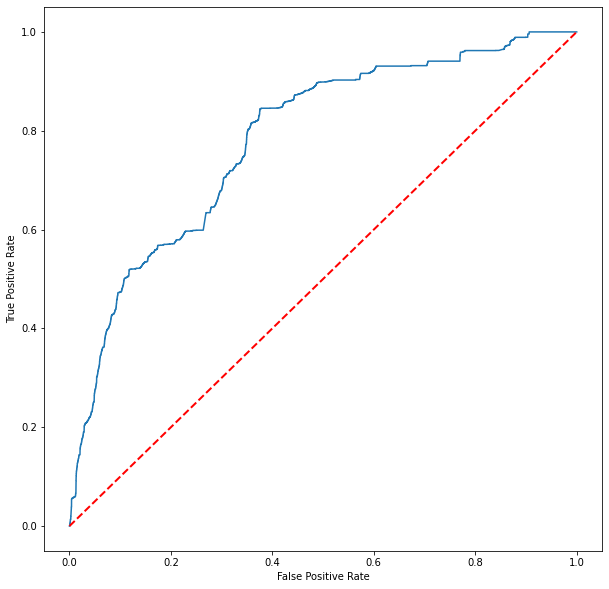

<function matplotlib.pyplot.show(close=None, block=None)>

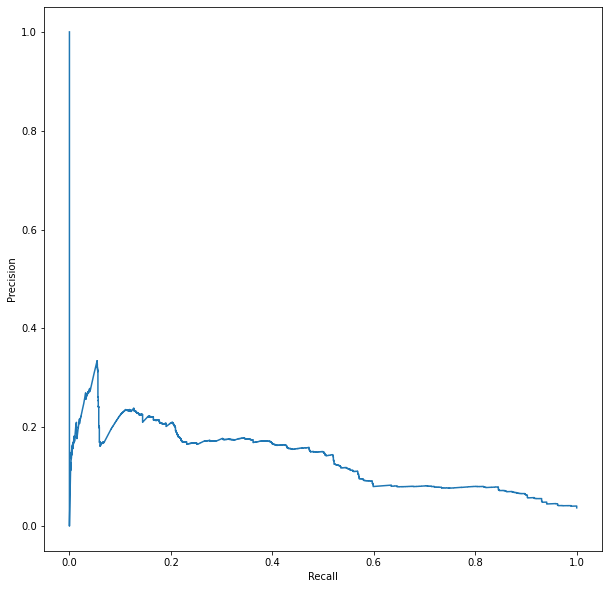

In [18]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

66/66 [==============================] - 1s 15ms/step
Print error: 4770	0.09731327387300528	


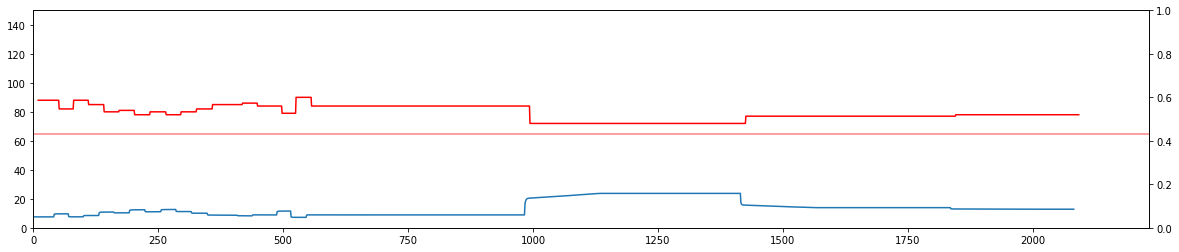

110/110 [==============================] - 2s 16ms/step
Print error: 4850	0.3169159375030297	


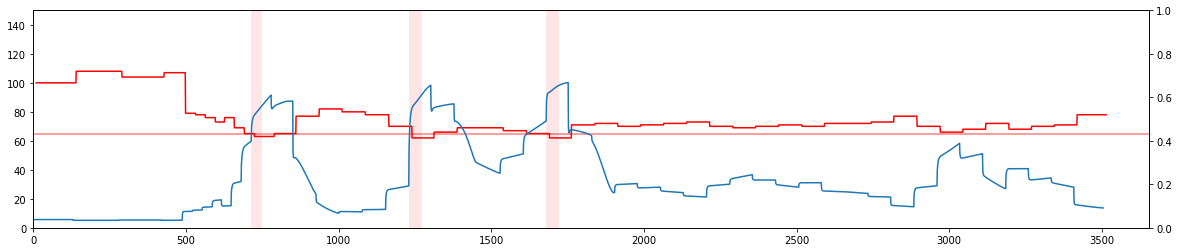

61/61 [==============================] - 2s 23ms/step
Print error: 4874	0.03473527345565718	


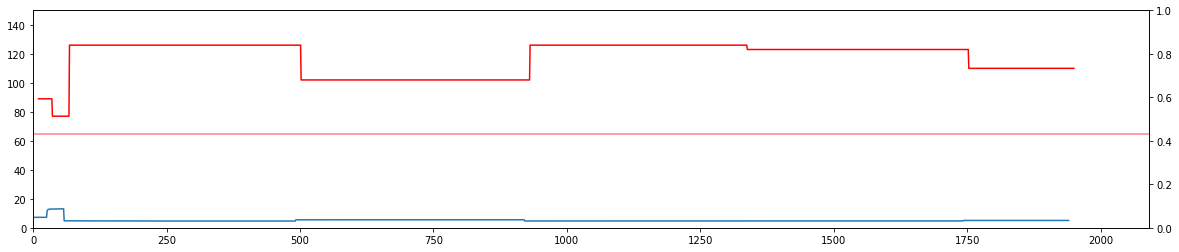

99/99 [==============================] - 4s 44ms/step
Print error: 4888	0.25306675853146815	


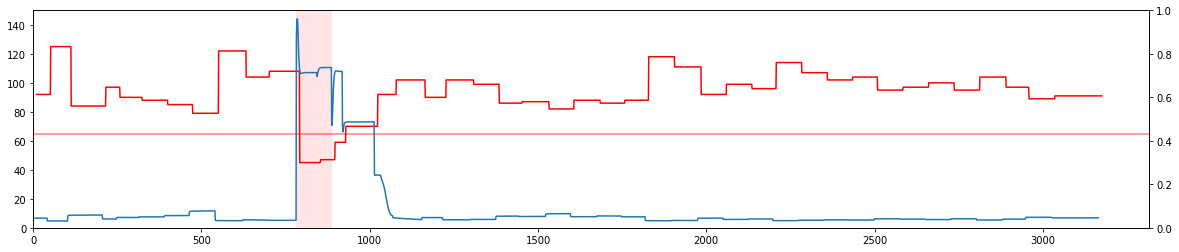

53/53 [==============================] - 2s 26ms/step
Print error: 4962	0.1508743878030564	


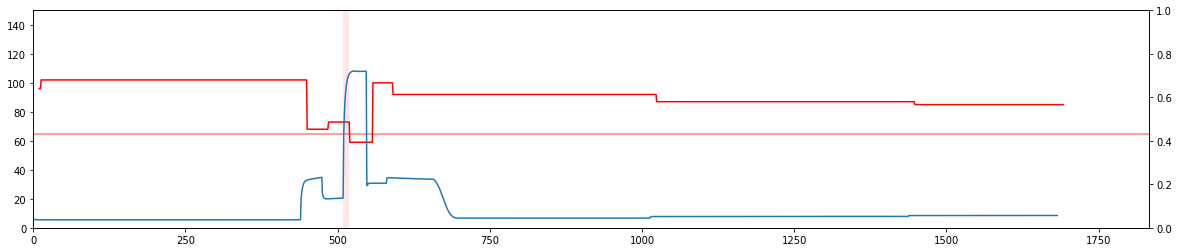

179/179 [==============================] - 4s 22ms/step
Print error: 5050	0.11254349486981516	


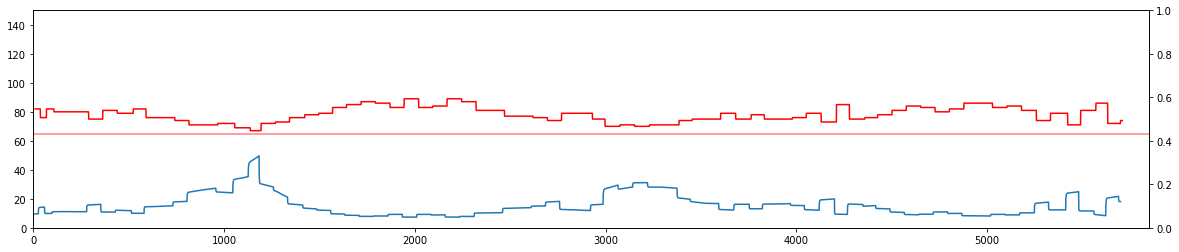

192/192 [==============================] - 5s 26ms/step
Print error: 5087	0.18500959004212356	


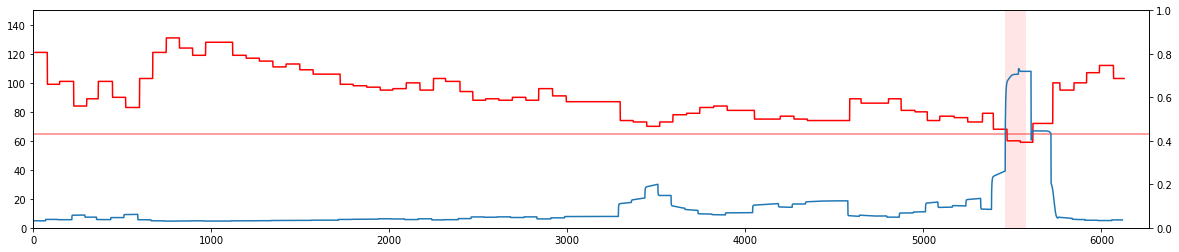

76/76 [==============================] - 3s 30ms/step
Print error: 5139	0.23874090760328376	


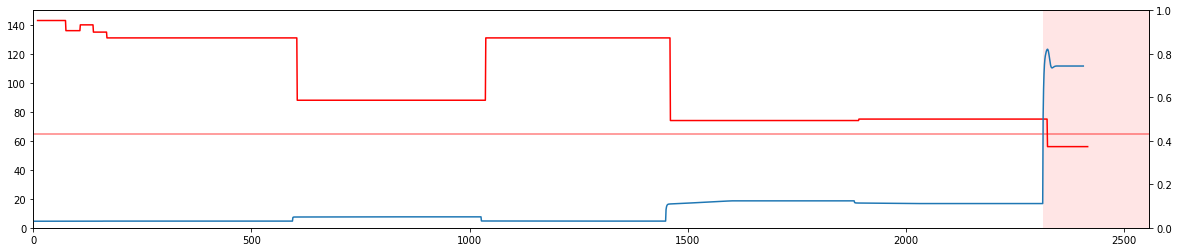

63/63 [==============================] - 2s 24ms/step
Print error: 5140	0.12744396397154228	


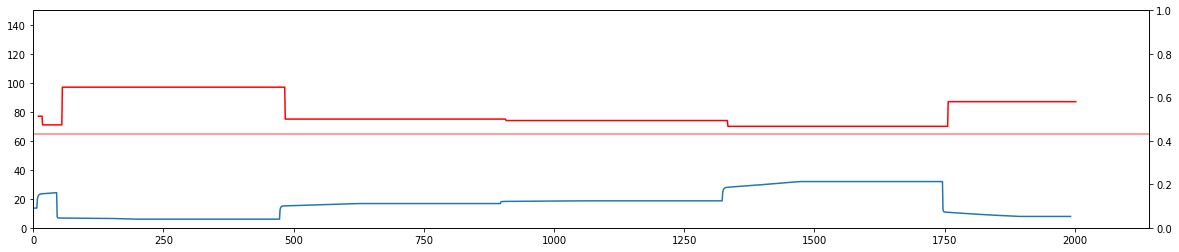

131/131 [==============================] - 3s 24ms/step
Print error: 5215	0.0691497916540595	


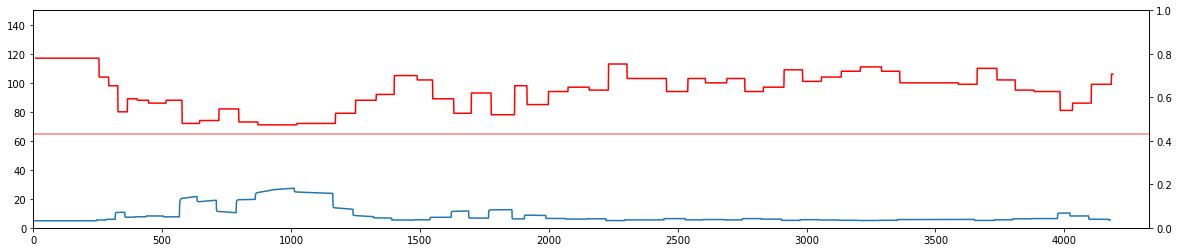

10/10 [==============================] - 0s 17ms/step
Print error: 5221	0.03264206291791414	


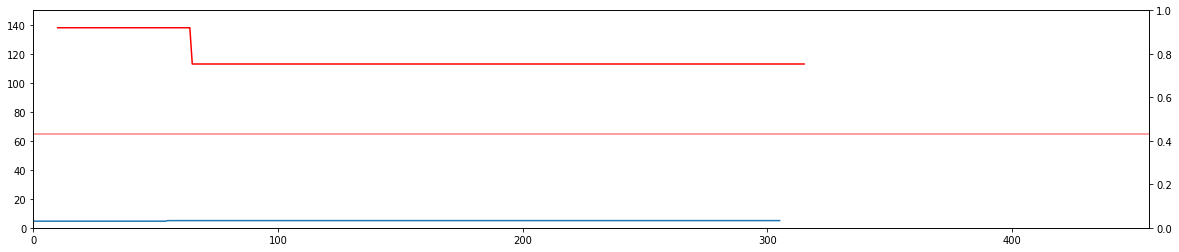

116/116 [==============================] - 2s 14ms/step
Print error: 5249	0.43579388785818185	


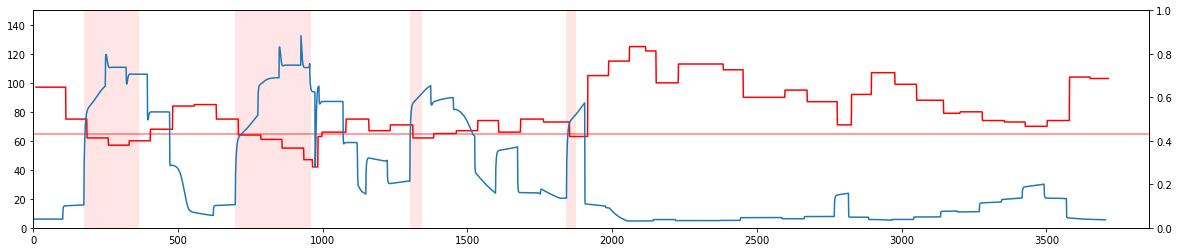

153/153 [==============================] - 2s 16ms/step
Print error: 5252	0.33470587848242883	


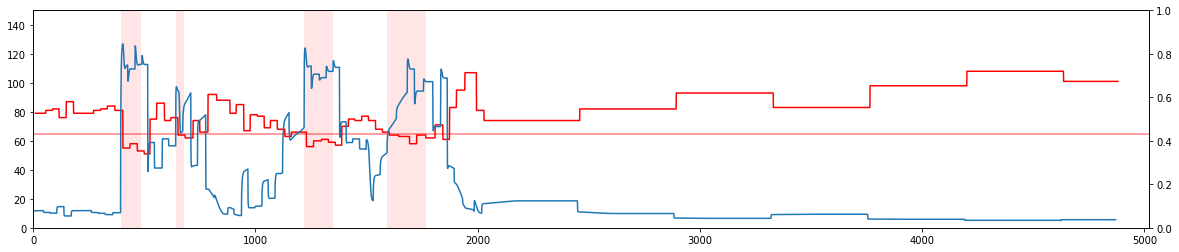

47/47 [==============================] - 1s 15ms/step
Print error: 5295	0.05916457675728978	


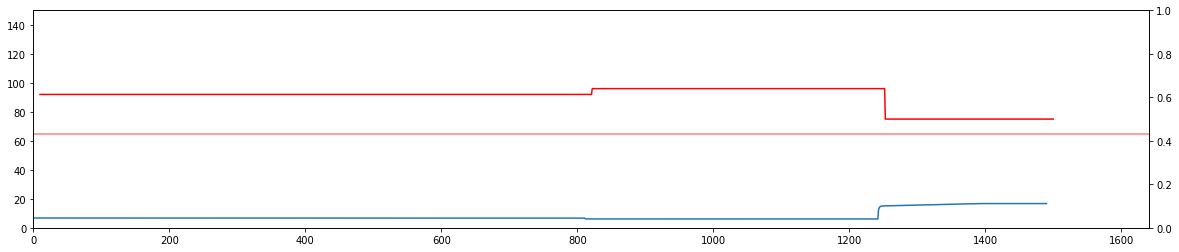

112/112 [==============================] - 3s 30ms/step
Print error: 5378	0.047009652175141976	


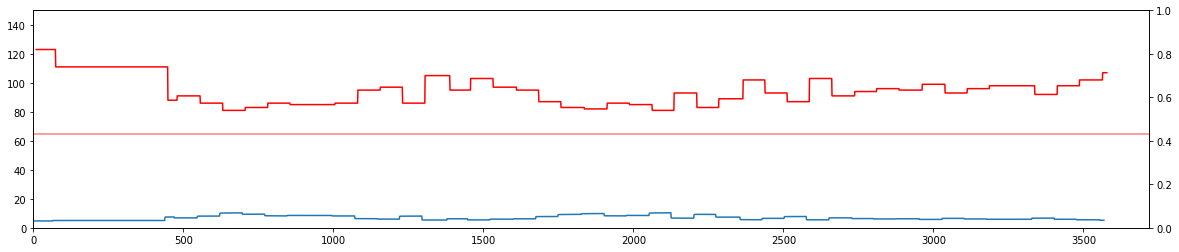

29/29 [==============================] - 1s 39ms/step
Print error: 5395	0.05860561409682865	


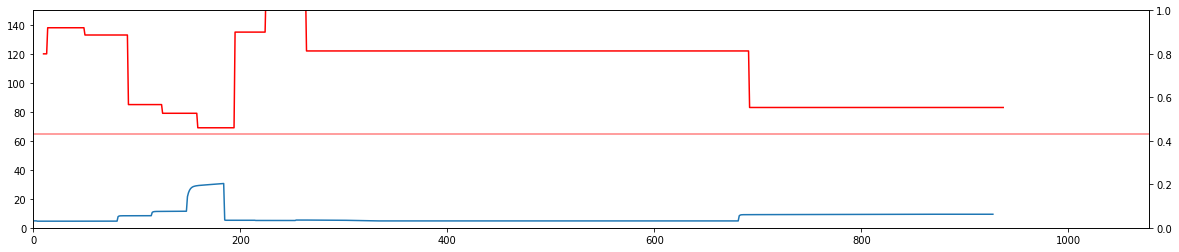

75/75 [==============================] - 3s 35ms/step
Print error: 5402	0.05592782496649318	


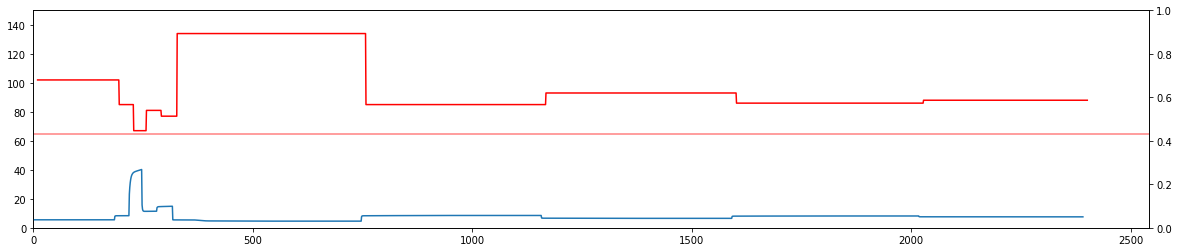

10/10 [==============================] - 0s 21ms/step
Print error: 5568	0.2550464265764853	


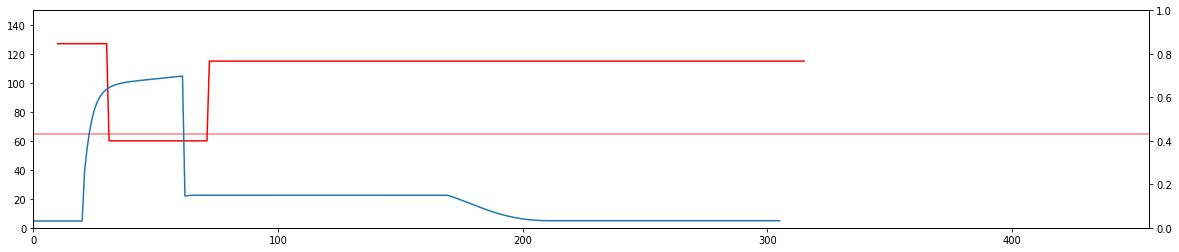

109/109 [==============================] - 3s 29ms/step
Print error: 5570	0.3585192817040981	


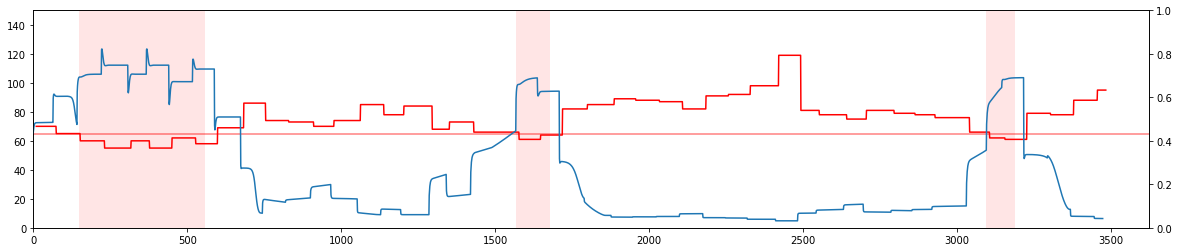

43/43 [==============================] - 1s 14ms/step
Print error: 5658	0.17417124305782247	


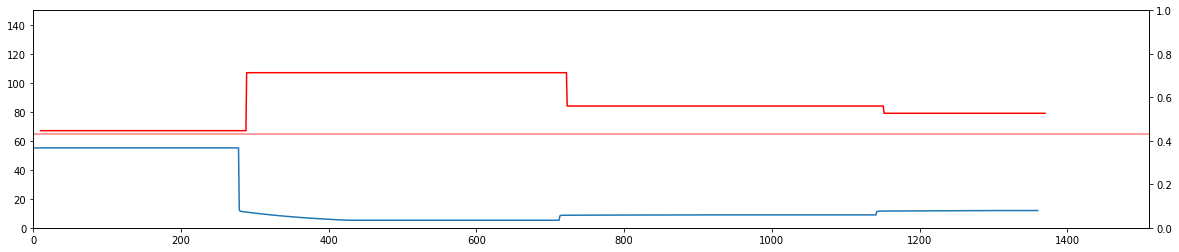

203/203 [==============================] - 4s 20ms/step
Print error: 5737	0.257249274731977	


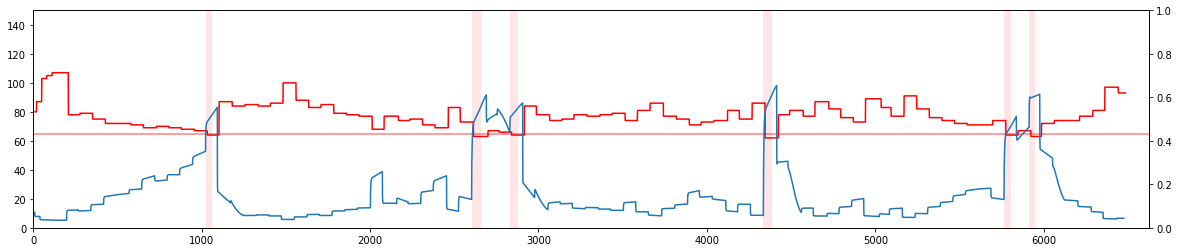

130/130 [==============================] - 5s 34ms/step
Print error: 5741	0.06967088896949164	


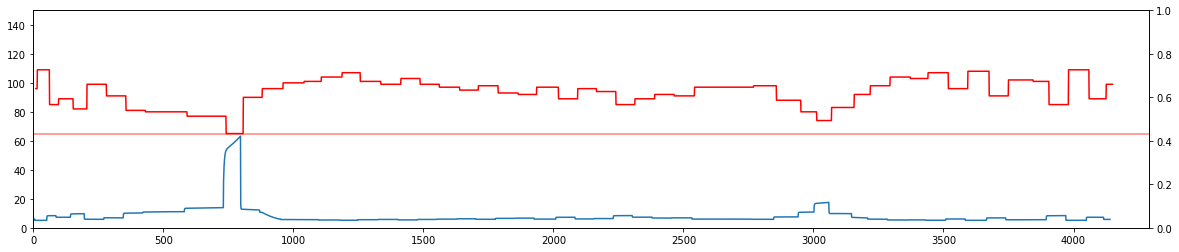

105/105 [==============================] - 2s 21ms/step
Print error: 5742	0.3684922230584408	


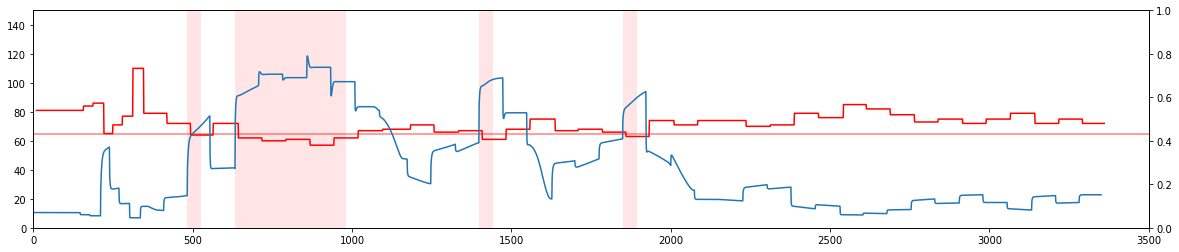

202/202 [==============================] - 6s 29ms/step
Print error: 5764	0.2935638867914597	


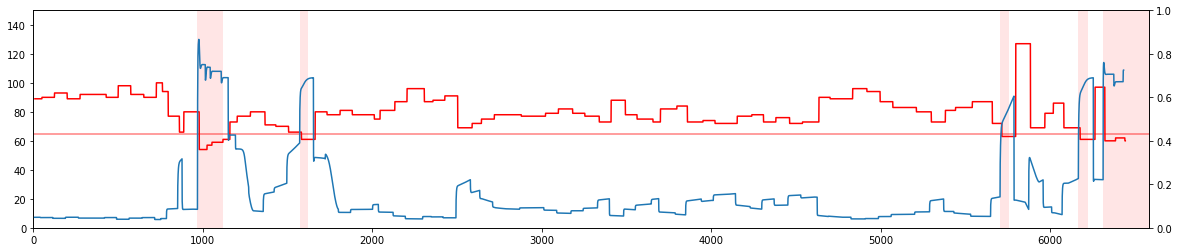

139/139 [==============================] - 2s 11ms/step
Print error: 5984	0.08661944840426486	


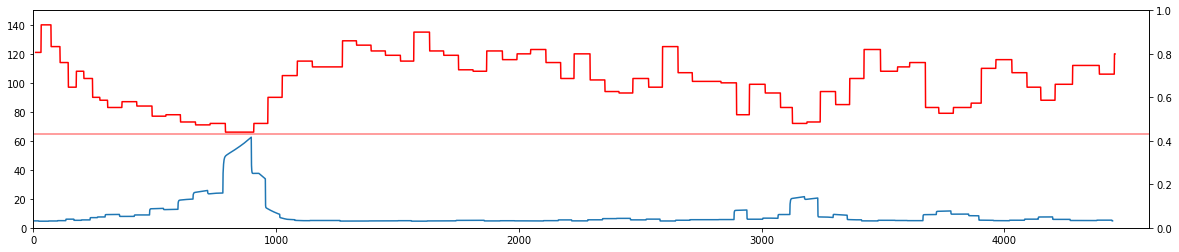

113/113 [==============================] - 1s 11ms/step
Print error: 6137	0.17524064433345365	


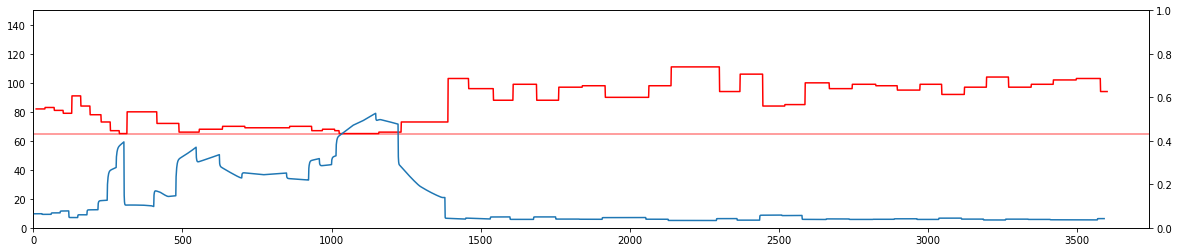

232/232 [==============================] - 4s 18ms/step
Print error: 6181	0.2724126684166354	


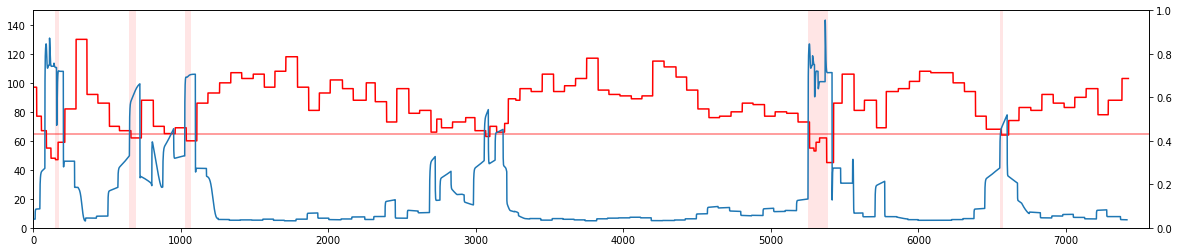

36/36 [==============================] - 1s 27ms/step
Print error: 6210	0.059790059389895206	


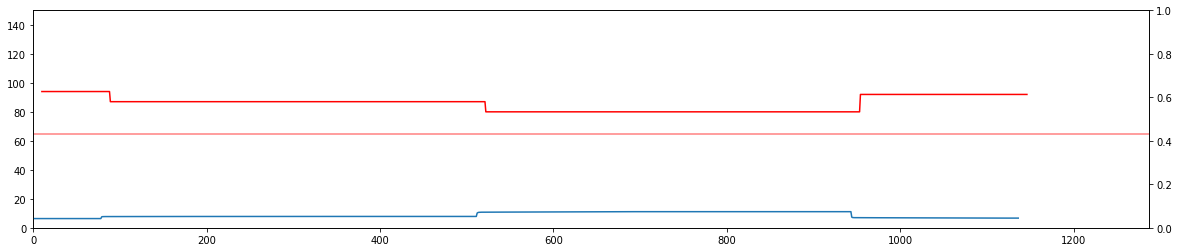

40/40 [==============================] - 2s 34ms/step
Print error: 6214	0.09749024109265758	


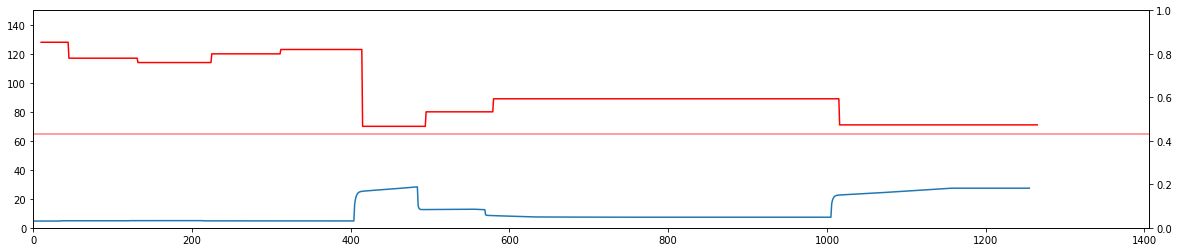

152/152 [==============================] - 4s 23ms/step
Print error: 6231	0.10442623838081258	


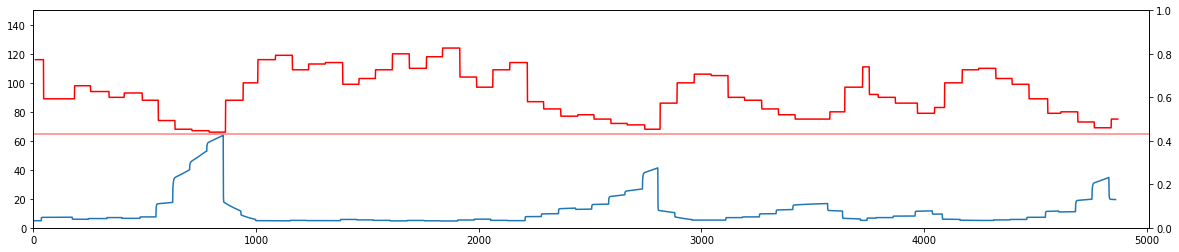

190/190 [==============================] - 6s 31ms/step
Print error: 6272	0.25853149263916286	


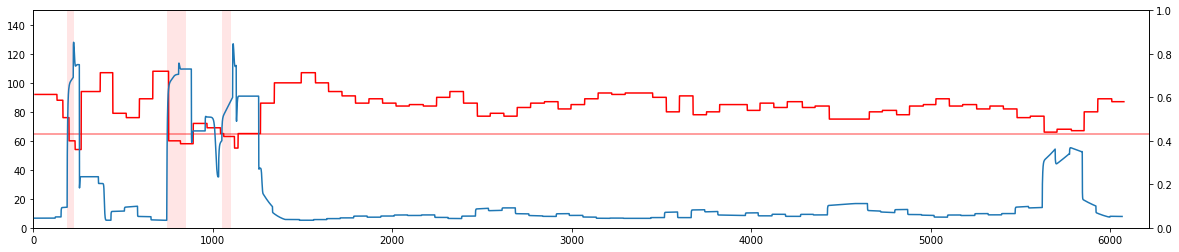

47/47 [==============================] - 2s 38ms/step
Print error: 6317	0.13318695546338286	


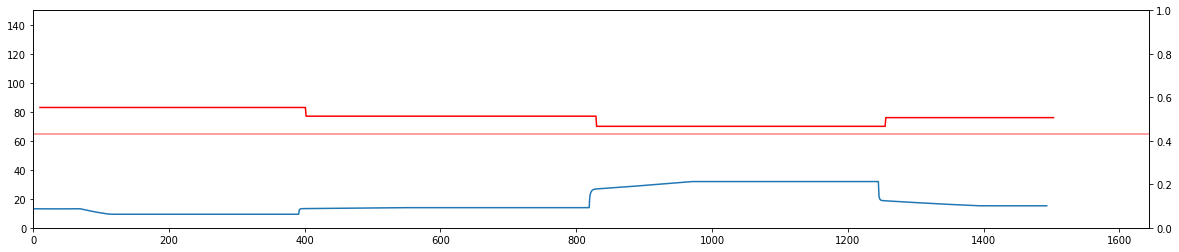

326/326 [==============================] - 14s 43ms/step
Print error: 6356	0.2335735446267249	


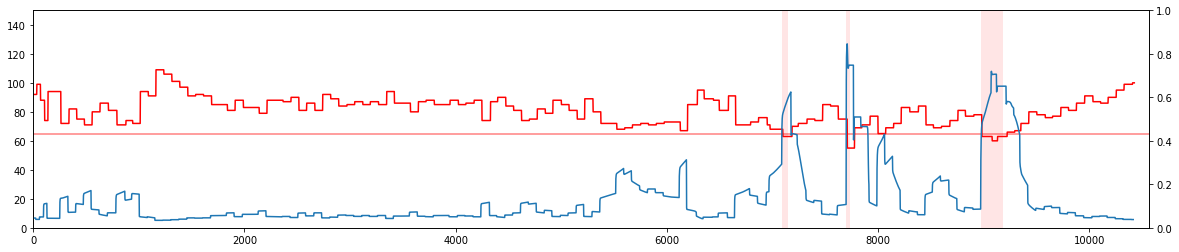

In [19]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()